# Part 5.2 Comparing
## Compare predictions with OpenStreetMap (OSM)

Now that the predicted geocoordinates have been collected, it is time to compare the reuslts with the already mapped refuge islands on OSM. The goal is to find objects that are not yet mapped, to eventually help keeping OSM up-to-date.

In [28]:
import os
import json
import overpass
import itertools
from geojson import Feature, Point, FeatureCollection, dump
import numpy as np

In [5]:
cwd= os.getcwd()

### Coordinates from overpass API

The GEOJSON files for the mapped islands on OSM are created with the Overpass Turbo API: https://python-overpy.readthedocs.io/en/latest/example.html

You can retrieve data for a specified area and then store a GEOJSON on your current directory. In this example, islands for all over Switzerland, East-Switzerland (excl. Graubünden) and Zurich have been retrieved and stored. 
>If other regions are chosen, the name of the file types must be changed below.

In [14]:
query_east = """(area["name"="Sankt Gallen"];
                     area["name"="Thurgau"];
                     area["name"="Appenzell Innerrhoden"];
                     area["name"="Appenzell Ausserrhoden"];
                     area["name"="Schaffhausen"];
                     area["name"="Glarus"];
                     area["name"="Graubünden/Grischun/Grigioni"];
                     );
                     (nw["crossing:island"="yes"](area););"""

query_zh = """area["name"="Zürich"];
                     (nw["crossing:island"="yes"](area););"""

query_ch = """area["name"="Schweiz/Suisse/Svizzera/Svizra"];
                     (nw["crossing:island"="yes"](area););"""

In [29]:
api = overpass.API()
result = api.get(query_east)
with open('CH_East_Islands.geojson', 'w') as fd:
     geojson.dump(result,fd)
print("File successfully stored under: " + str(cwd))

File successfully stored under: *


In [10]:
api = overpass.API()
result = api.get(query_zh)
with open('ZH_Islands.geojson', 'w') as fd:
     geojson.dump(result,fd)
print("File successfully stored under: " + str(cwd))

File successfully stored under: *cwd


In [11]:
api = overpass.API()
result = api.get(query_ch)
with open('CH_ALL_Islands.geojson', 'w') as fd:
     geojson.dump(result,fd)
print("File successfully stored under: " + str(cwd))

File successfully stored under: *cwd


#### Data extraction from complex JSON

The below function does the following two things:

- Extract the coordinates and puts them in a python list as tuples
- Creates a set with the same tuples but with rounded values (needed for comparison since the coordinates deviate by some meters)

In [12]:
def coordinates_extract(file): 
    """Recursively extract coordinates from nested geojson"""
    with open(file) as f:
        data = json.load(f)
    
    org_coor = []
        
    for feature in data['features']:  
          for cood in feature['geometry']['coordinates']:
            org_coor.append(cood)
    
    # Need to zip the coordinates back to a tuple in order to compare them better
    real_coordinates = [(org_coor[i], org_coor[i+1]) for i in range(0, len(org_coor)-1,2)]
    
    return real_coordinates

Load the files and count the number of predicted and mapped refuge islands.

In [16]:
pred_co = coordinates_extract("predicted_islands.geojson")
east_co = coordinates_extract("CH_East_Islands.geojson")
zh_co = coordinates_extract("ZH_Islands.geojson")
ch_co = coordinates_extract("CH_ALL_Islands.geojson")

print("There are " + str(len(pred_co))+ " refuge islands coordinates predicted by the model")
print("There are " + str(len(east_co))+ " refuge islands mapped in OSM for the eastern part of Switzerland")
print("There are " + str(len(zh_co))+ " refuge islands mapped in OSM for the region of Zurich")
print("There are " + str(len(ch_co))+ " refuge islands mapped in OSM all over Switzerland")

There are 659 refuge islands coordinates predicted by the model
There are 1161 refuge islands mapped in OSM for the eastern part of Switzerland
There are 2326 refuge islands mapped in OSM for the region of Zurich
There are 9090 refuge islands mapped in OSM all over Switzerland


In oder to compare the coordinates numpy.isclose() function is used. It allows to compare if two arrays are element-wise equal within a certain tolerance. This is required because none of the predicted coordinates will match over six decimal places exactly. 
>This may be caused by a slight deviation in the centric point when the polygons where drawn (the polygon coordinates needed to create the masks)

In [17]:
pred = np.array(pred_co,dtype=float)
east = np.array(east_co,dtype=float)
zh = np.array(zh_co,dtype=float)
ch = np.array(ch_co, dtype=float)

With the help of the itertools() function, two arrays are compared and the matching coordinates are stored in a new array.

In [18]:
def get_matching_coordinates(array1, array2):
    "You get the matching tuples of the second array you input - array2"
    output = np.empty((0,2))
    for i0, i1 in itertools.product(np.arange(array1.shape[0]),
                                np.arange(array2.shape[0])):
        if np.all(np.isclose(array1[i0], array2[i1], atol=1e-2)):
             output = np.concatenate((output, [array2[i1]]), axis=0)
    return output

In [19]:
pred_islands_east = np.unique(get_matching_coordinates(east, pred), axis=0)
print("The model predicted " + str(pred_islands_east.shape[0]) + " islands in the eastern part of Switzerland")

The model predicted 158 islands in the eastern part of Switzerland


In [20]:
pred_islands_zh = np.unique(get_matching_coordinates(zh, pred), axis=0)
print("The model predicted " + str(pred_islands_zh.shape[0]) + " islands in the region of Zurich")

The model predicted 425 islands in the region of Zurich


In [21]:
# this takes a while due to many iterations
pred_islands_ch = np.unique(get_matching_coordinates(ch, pred), axis=0)
print("The model predicted " + str(pred_islands_ch.shape[0]) + " islands all over Switzerland")

The model predicted 623 islands all over Switzerland


In [22]:
def setdiff2d_list(arr1, arr2):
    "This is to extract the not matching coordinates (tolerance given 1e-2)"
    delta = set(map(tuple, arr2))
    return np.array([x for x in arr1 if tuple(x) not in delta])

In [23]:
diff = setdiff2d_list(pred, pred_islands_ch)

In [25]:
print("There are " + str(diff.shape[0]) + " island predicted by the model that could not be matched with the data from Overpass")
print("These are the coordinates to check: ")
diff

There are 35 island predicted by the model that could not be matched with the data from Overpass
These are the coordinates to check: 


array([[ 8.406138, 47.62724 ],
       [ 9.509071, 47.171726],
       [ 9.519528, 47.209463],
       [ 9.519463, 47.209466],
       [ 9.56208 , 47.211248],
       [ 9.524224, 47.111374],
       [ 9.656417, 47.438343],
       [ 8.448174, 47.573177],
       [ 9.652101, 47.339793],
       [ 8.840192, 47.734772],
       [ 8.450472, 47.745655],
       [ 9.658961, 47.463823],
       [ 9.522085, 47.178284],
       [ 9.159182, 47.674564],
       [ 8.562951, 47.647076],
       [ 9.658292, 47.463033],
       [ 8.991149, 47.691624],
       [ 8.90105 , 47.723057],
       [ 9.517187, 47.132741],
       [ 9.652313, 47.34012 ],
       [ 8.850466, 47.740399],
       [ 8.577152, 47.65391 ],
       [ 9.522092, 47.178285],
       [ 8.899529, 47.732739],
       [ 9.179365, 47.671934],
       [ 9.51216 , 47.177936],
       [ 9.516892, 47.170689],
       [ 9.521781, 47.178595],
       [ 8.853572, 47.735777],
       [ 9.656165, 47.462073],
       [ 9.164588, 47.671853],
       [ 9.16453 , 47.671856],
       [

In [34]:
feature_list = list()
    
for x,y in diff:
    feature_list.append(Feature(geometry=Point((x, y))))
  
unmatched_coor = FeatureCollection(feature_list)

In [35]:
with open('unmatched_islands.geojson','w') as fd:
        dump(unmatched_coor,fd)

The GeoJSON file can be use to locate the unmatched coordinates on a map (for example https://geojson.io)

The reason why the values did not match is because they are located outside of Switzerland. Region of interest, however, is only Switzerland. Thus, it can be stated the OSM is up-to-date, insofar the islands of this dataset are concerend.

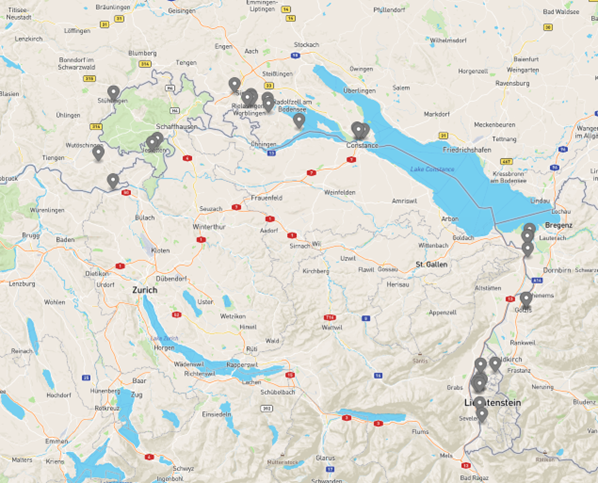